In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_betas
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows

In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

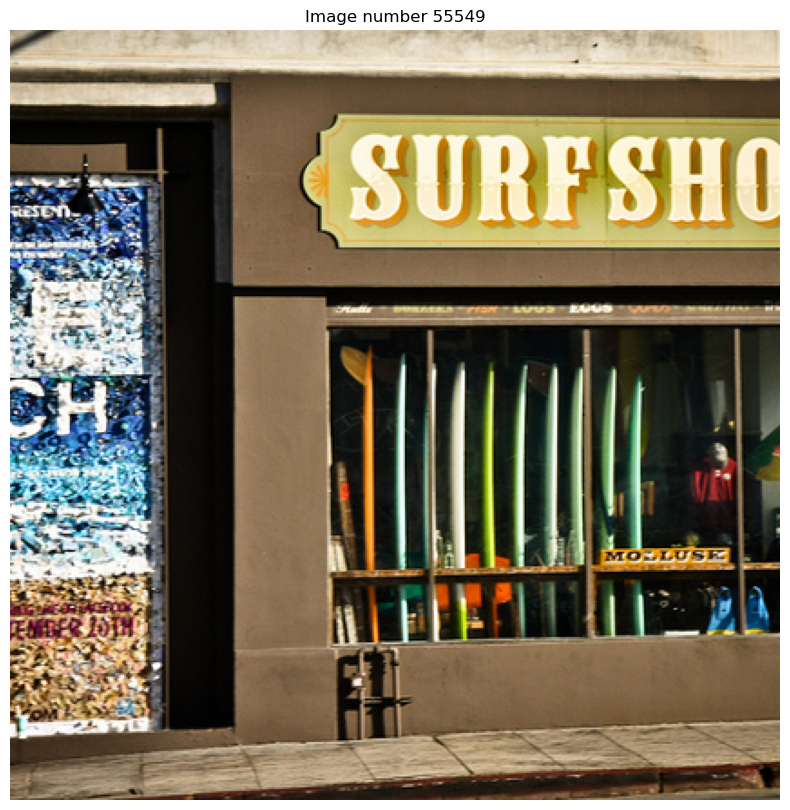

In [21]:
_ = show_stim()

In [4]:
with open('/home/rfpred/data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)


# # Load in the RMS contrast values for each image
all_rms = pd.read_pickle('all_rms_lab_df')
all_rms

rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
72995  32.597843
72996  19.921272
72997  54.109564
72998  28.464819
72999  18.567823

[73000 rows x 1 columns]

In [5]:
# Load in the design matrix
dmx = get_imgs_designmx()


In [6]:
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)
   
visfeats_rms

{'subj01': {'rms':        img_no        rms     rms_z     rms_mc
  0       46002  25.471033 -0.060673  -0.743838
  1       61882  22.462335 -0.306086  -3.752536
  2         828  18.877597 -0.598484  -7.337274
  3       67573  42.634550  1.339314  16.419679
  4       16020  16.612092 -0.783276  -9.602780
  ...       ...        ...       ...        ...
  29995   13773  22.456342 -0.306574  -3.758529
  29996   66767   8.632073 -1.434187 -17.582798
  29997   53167  27.830569  0.131789   1.615698
  29998    1943  20.272697 -0.484689  -5.942174
  29999    5033   8.638144 -1.433692 -17.576727
  
  [30000 rows x 4 columns],
  'rms_irrelevant':        img_no        rms     rms_z     rms_mc
  0       46002  43.184334  2.283840  26.304565
  1       61882   3.326942 -1.176696 -13.552826
  2         828   1.465250 -1.338334 -15.414519
  3       67573  10.215945 -0.578573  -6.663824
  4       16020  19.639215  0.239583   2.759446
  ...       ...        ...       ...        ...
  29995   13773   6.04

In [7]:
# # Standardize the root mean square values by turning them into z-scores
# rms_subj01_z = get_zscore(rms_subj01['rms'], print_ars = 'n')

# # Add the z-scored RMS contrast values to the dataframe
# if rms_subj01.shape[1] == 2:    
#     rms_subj01.insert(2,'rms_z', rms_subj01_z)

# print(rms_subj01)

In [8]:
# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
# Load in the saved masks for voxels with pRF inside central 1.25 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_strict_l.pkl', 'rb') as fp:
   prf_mask_center_strict_l = pickle.load(fp)    

# Load in the saved masks for voxels with pRF loosely (at least 50%) inside central 1 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_halfloose.pkl', 'rb') as fp:
   prf_mask_central_halfloose = pickle.load(fp)    

# Load in the saved masks for voxels with pRFs that have their center inside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 

# Load in the saved masks that have their pRFs exclusively outside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)

In [9]:
# This generally takes about 1.5 min per session.
# betas_ses1 = (nib.load('/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz')).get_fdata(caching = 'unchanged')

All this shit is to be able to alter the "voxels" argument, or the prf mask dicts, after they have been made (which takes a lot of time). By transforming the full, nifti-like numpy arrays into coordinate-only versions, we can check their sizes based on the information I have stored in the prf_dict object. Only thing I need to do is probably write a function to integrate the functions and to acquire the data from the prf_dict.

Acquire the beta values for a specific selection of voxels, a specific subject, and a specific range of sessions. Generally works well, but crashes the kernel in rare cases.

In [16]:
central_betas_halfloose3 = get_betas('subj01', prf_mask_central_halfloose, 31, 39, prf_region = 'center_halfloose')

Working on session: 32 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 33 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 34 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 35 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 36 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 37 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 38 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 39 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 40 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

     - Back-up saved to beta_dict{start_session}_{end_session}.pkl



In [16]:

betas_periphery = get_betas('subj01', prf_mask_periphery_strict, 36, 39, prf_region = 'periphery')


Working on session: 1 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 2 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

     - Back-up saved to beta_dict{start_session}_{end_session}.pkl



Still have to run this line till it reaches 40, also need to do the whole RMS calculations again

In [10]:

central_betas_strict_l = get_betas('subj01', prf_mask_center_strict_l, 21, 39, prf_region = 'center_strict_l')

Working on session: 22 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 23 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 24 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 25 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 26 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 27 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 28 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 29 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 30 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 31 of subject: subj01
     - Back-up saved to intermediate_hrf_save.pkl

Working on session: 32 of subject: subj01
     - Back-up saved to inte

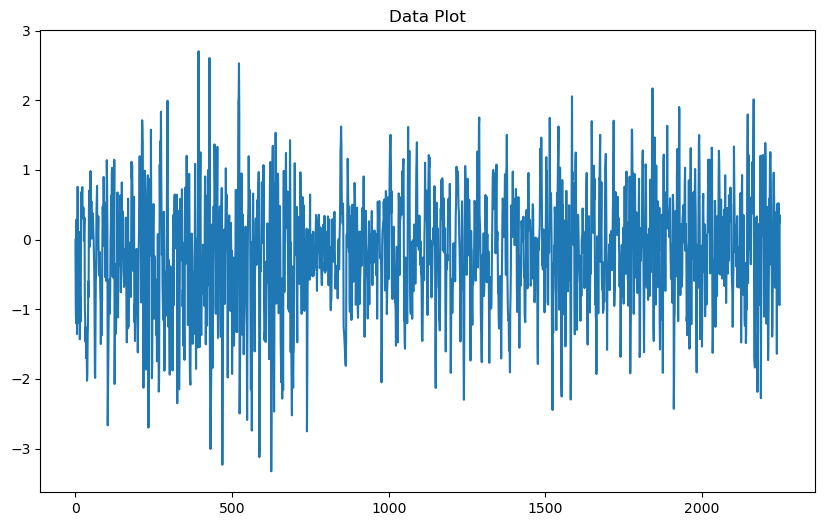

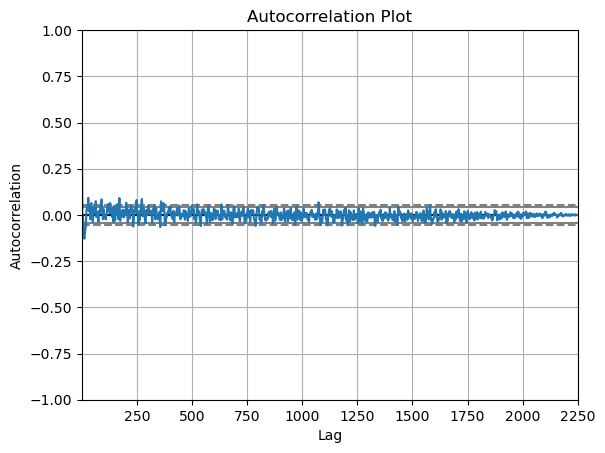

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming beta_dict38_40['subj01']['V1_mask']['voxel1'] is a list or a pandas Series
data = beta_dict0_2['subj01']['V1_mask']['voxel1']
# data = hrf_dict['subj01']['V1_mask']['voxel1']['hrf_betas'][:1500]
# data = hrf_dict['subj01']['V1_mask']['voxel1']['hrf_betas'][1500:3000]


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Data Plot')
plt.show()

# Checking for large iterating patterns using autocorrelation
pd.plotting.autocorrelation_plot(data)
plt.title('Autocorrelation Plot')
plt.show()

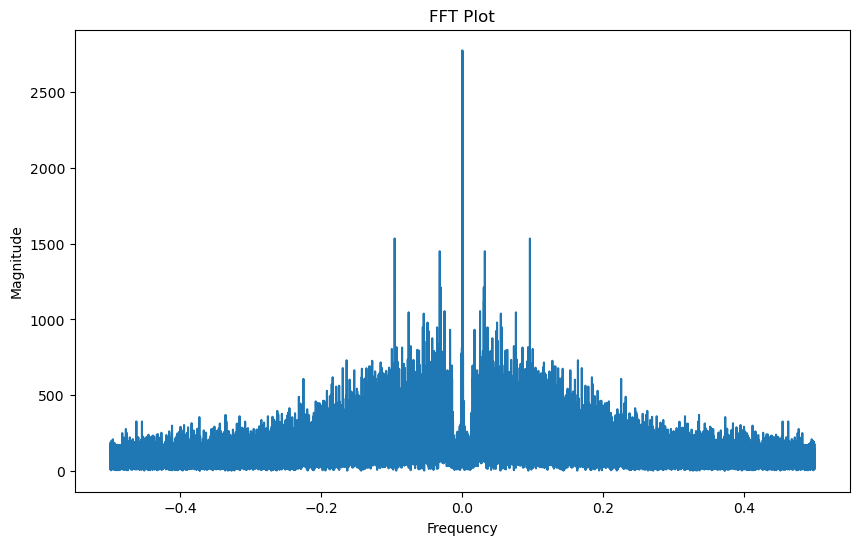

In [83]:
import numpy as np

# Compute the one-dimensional n-point discrete Fourier Transform
fft_result = np.fft.fft(data)

# Compute the absolute value of the result, which represents the magnitude of the frequencies
fft_abs = np.abs(fft_result)

# Compute the frequencies associated with the FFT values
fft_freq = np.fft.fftfreq(len(data))

# Plot the absolute value of the FFT result
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, fft_abs)
plt.title('FFT Plot')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

What I need is a script to integrate all the separate beta_dicts into an aggreggated one, also including the voxel coordinates.

In [28]:
import copy
import seaborn as sns
# Function to create a dictionary containing all the relevant HRF signal info for the relevant voxels.
def get_hrf_dict(subjects, voxels, prf_region = 'center_strict', min_size = .1, max_size = 1, prf_proc_dict = None, vox_n_cutoff = None, plot_sizes = 'n'):
    
    hrf_dict = {}
    voxdict_select = {}
    
    for subject in [subjects]:
        hrf_dict[subject] = {}
        voxdict_select[subject] = {}

        # Get a list of files in the directory
        files = os.listdir(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/')

        # Filter files that start with "beta_dict" and end with ".pkl"
        filtered_files = [file for file in files if file.startswith("beta_dict") and file.endswith(".pkl")]

        # Sort files based on the first number after 'beta_dict'
        sorted_files = sorted(filtered_files, key=lambda x: int(''.join(filter(str.isdigit, x.split('beta_dict')[1]))))

        # Print the sorted file names
        for n_file, file_name in enumerate(sorted_files):
            print(file_name)
                
            # Load in the boolean mask for inner circle voxel selection per roi.
            with open(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/{file_name}', 'rb') as fp:
                beta_session = pickle.load(fp)
            
            rois = list(beta_session[subject].keys())

            if n_file == 0:
                hrf_dict[subject] = copy.deepcopy(beta_session[subject])
            for i, roi in enumerate(rois):

                
                voxel_mask = voxels[subject][roi] # These is the boolean mask for the specific subject, roi
                if vox_n_cutoff == None:
                    vox_n_cutoff = numpy2coords(voxel_mask).shape[0]
                if min_size != None and max_size != None:
                    preselect_voxels = numpy2coords(voxel_mask)[:vox_n_cutoff,:] # This cutoff is to allow for checking whether the amount of voxels per category matters (peripher/central)
                    size_selected_voxels = filter_array_by_size(prf_proc_dict[subject]['proc'][roi]['size'], min_size, max_size)
                    joint_voxels = find_common_rows(preselect_voxels, size_selected_voxels)
                    voxel_mask = coords2numpy(joint_voxels, voxels['subj01']['V1_mask'].shape) * 1
                    
                    # Acquire the specific RF sizes for inspection, plots.
                    vox_slct = joint_voxels.reshape(-1, 1, joint_voxels.shape[1])
                    sizes_reshape = size_selected_voxels[:, :3].reshape(1, -1, size_selected_voxels.shape[1]-1)
                    equal_rows = np.all(vox_slct == sizes_reshape, axis = 2)
                    matching_rows = np.any(equal_rows, axis=0)
                    size_slct = size_selected_voxels[matching_rows]
                    
                voxdict_select[subject][roi] = voxel_mask
                n_voxels = numpy2coords(voxel_mask).shape[0]
                print(f'\tAmount of voxels: {n_voxels}')

                vox_indices = np.zeros([n_voxels, 3], dtype = int) # Initiate an empty array to store vox indices
                hrf_dict[subject][roi]['roi_sizes'] = size_slct
                for coordinate in range(vox_indices.shape[1]): # Fill the array with the voxel coordinates as indices
                    vox_indices[:, coordinate] = np.where(voxel_mask == 1)[coordinate]
                    
                # for voxel in range(len(beta_session[subject][roi])):
                for voxel in range(n_voxels):
                    hrf_betas_ses = copy.deepcopy(beta_session[subject][roi][f'voxel{voxel + 1}'])
                    
                    if n_file == 0:
                        total_betas = hrf_betas_ses
                        hrf_dict[subject][roi][f'voxel{voxel+1}'] = {
                            'xyz': list(vox_indices[voxel]),
                            'size': size_slct[voxel][3],
                            'hrf_betas': total_betas,
                            'hrf_betas_z': 0,
                            'hrf_rsquared': 0,
                            'hrf_rsquared_z': 0
                        }
                             
                    else: 
                        old_betas = hrf_dict[subject][roi][f'voxel{voxel + 1}']['hrf_betas']
                        hrf_dict[subject][roi][f'voxel{voxel + 1}']['hrf_betas']
                        total_betas = np.append(old_betas, hrf_betas_ses)   
                             
                    hrf_dict[subject][roi][f'voxel{voxel+1}'] = {
                        'xyz': list(vox_indices[voxel]),
                        'size': size_slct[voxel][3],
                        'hrf_betas': total_betas,
                        'hrf_betas_z': 0,
                        'hrf_rsquared': 0,
                        'hrf_rsquared_z': 0
                    }
            n_betas = len(hrf_dict[subject][roi][f'voxel{voxel+1}']['hrf_betas'])
            print(f'\tProcessed images: {n_betas}')

    if plot_sizes == 'y':
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create a figure with 2x2 subplots
        axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing
        cmap = plt.get_cmap('ocean')  # Get the 'viridis' color map
        for i, roi in enumerate(rois):
            sizes = hrf_dict[subject][roi]['roi_sizes'][:, 3]
            color = cmap(i / len(rois))  # Get a color from the color map
            sns.histplot(sizes, kde=True, ax=axs[i], color=color)  # Plot on the i-th subplot
            axs[i].set_title(f'RF sizes for {roi[:2]} (n={sizes.shape[0]})')  # Include the number of voxels in the title
            axs[i].set_xlim([min_size-.1, max_size+.1])  # Set the x-axis limit from 0 to 2
        fig.suptitle(f'{prf_region}', fontsize=18)
        plt.tight_layout()
        plt.show()
                
    with open(f'./data/custom_files/{subjects}hrf_dict.pkl', 'wb') as fp:
        pickle.dump(hrf_dict, fp)
    
            
    return hrf_dict, voxdict_select, joint_voxels, size_selected_voxels

beta_dict0_5_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 4500
beta_dict6_15_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 12000
beta_dict16_25_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 19500
beta_dict26_35_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 27000
beta_dict36_39_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 30000


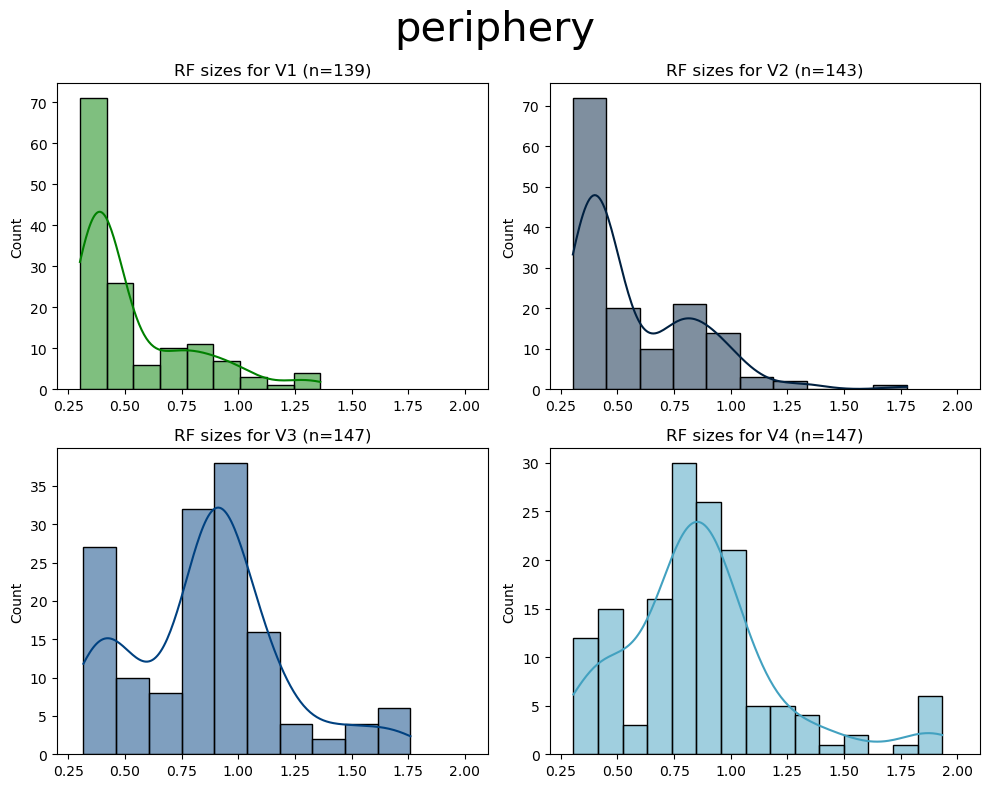

In [29]:
# Create the hrf_dict for the periphery with sizes .2 to 1

hrf_dict_peri, voxmask_tight_peri, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_periphery_strict, prf_region = 'periphery', 
                                                                    min_size = .3, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 160, plot_sizes = 'y')

In [30]:
hrf_dict_peri['subj01']['V1_mask']['voxel1']

{'xyz': [60, 14, 67],
 'size': 0.41766,
 'hrf_betas': array([ 4.17   ,  3.61333,  1.37667, ..., -0.03667, -2.62333, -3.82333]),
 'hrf_betas_z': 0,
 'hrf_rsquared': 0,
 'hrf_rsquared_z': 0}

beta_dict0_5_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 4500
beta_dict6_15_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 12000
beta_dict16_25_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 19500
beta_dict26_35_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 27000
beta_dict36_39_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 30000


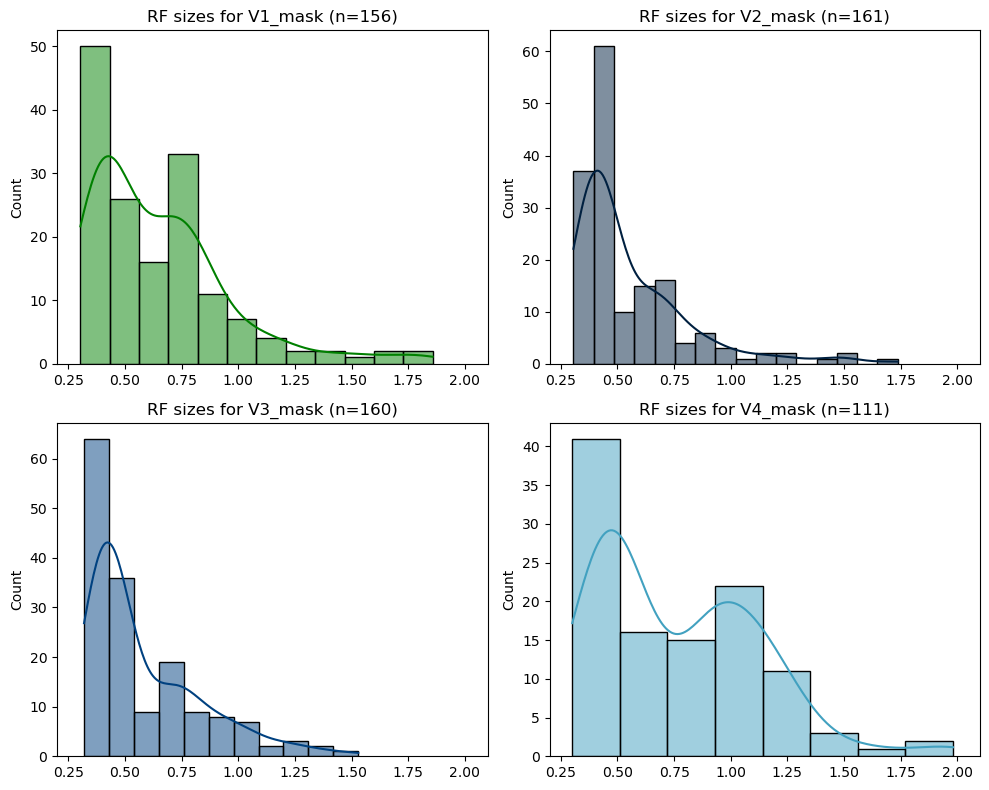

In [24]:
# Create the hrf_dict for the periphery with sizes .2 to 1

hrf_dict_central_loose, voxmask_tight_central_loose, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_central_loose, prf_region = 'center_loose', 
                                                                    min_size = .3, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = None, plot_sizes = 'y')

beta_dict0_2.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 27000
beta_dict36_39.pkl
	Amount of voxels: 98
	Amount of voxels: 171

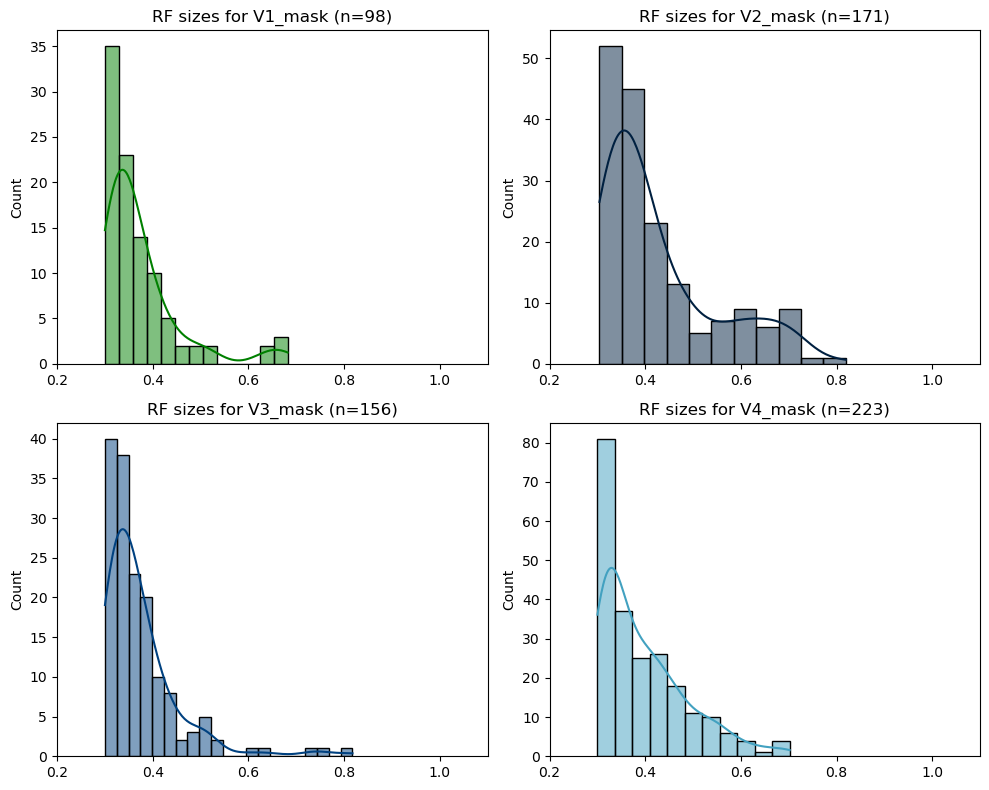

In [25]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .3, max_size = 1, prf_proc_dict = prf_dict, plot_sizes = 'y')






beta_dict0_2.pkl
2250
beta_dict3_5.pkl
4500
beta_dict6_10.pkl
8250
beta_dict11_15.pkl
12000
beta_dict16_20.pkl
15750
beta_dict21_27.pkl
21000
beta_dict28_35.pkl
27000
beta_dict36_39.pkl
30000


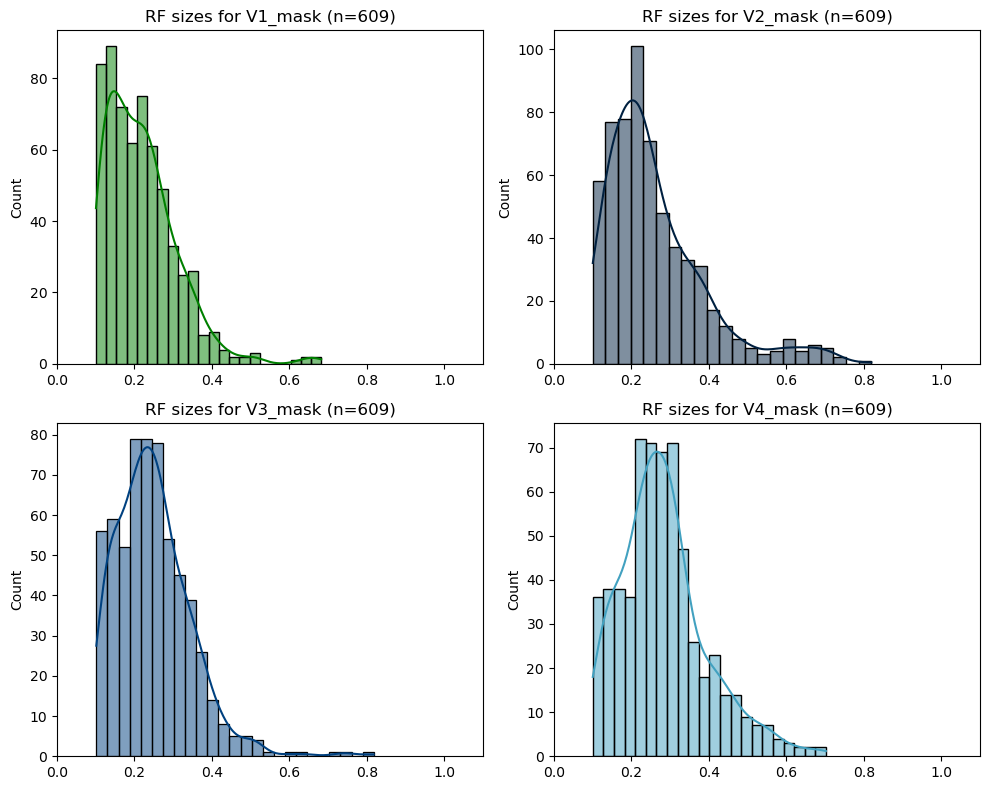

In [197]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .1, max_size = 1, prf_proc_dict = prf_dict, plot_sizes = 'y')





beta_dict0_9_center_strict_l.pkl
	Amount of voxels: 104
	Amount of voxels: 112
	Amount of voxels: 107
	Amount of voxels: 150
	Processed images: 7500
beta_dict10_20_center_strict_l.pkl
	Amount of voxels: 104
	Amount of voxels: 112
	Amount of voxels: 107
	Amount of voxels: 150
	Processed images: 15750
beta_dict21_39_center_strict_l.pkl
	Amount of voxels: 104
	Amount of voxels: 112
	Amount of voxels: 107
	Amount of voxels: 150
	Processed images: 30000


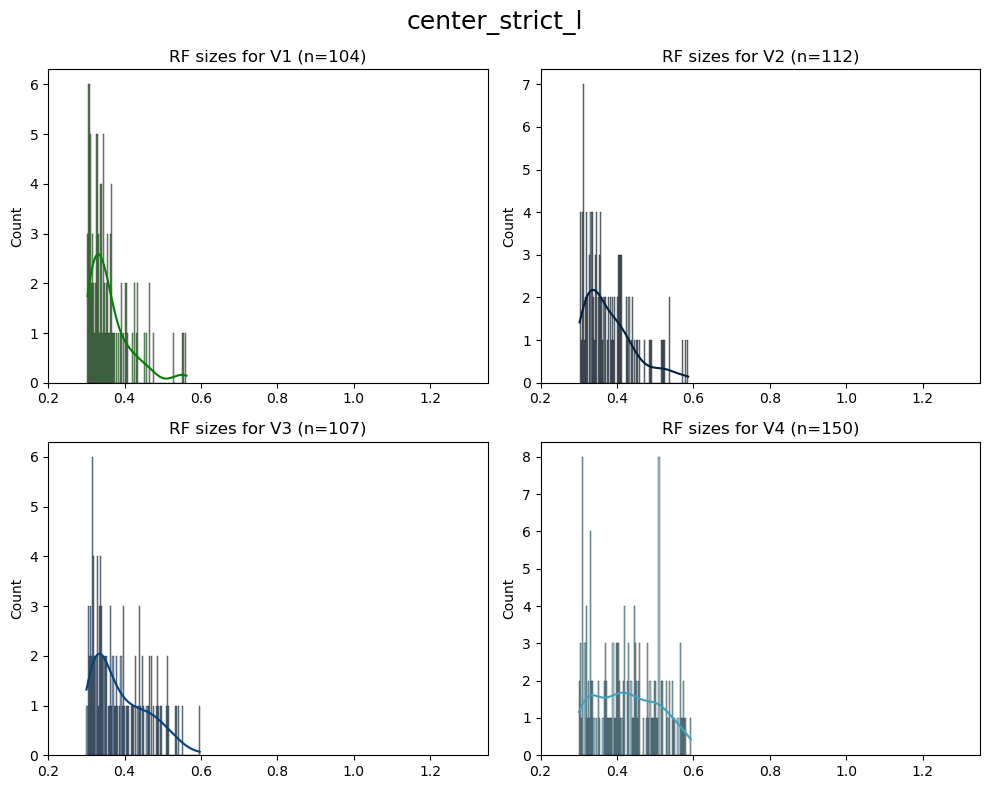

In [55]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight_l, voxmask_tight_l, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict_l, prf_region = 'center_strict_l', 
                                             min_size = .3, max_size = 1.25, prf_proc_dict = prf_dict, plot_sizes = 'y')



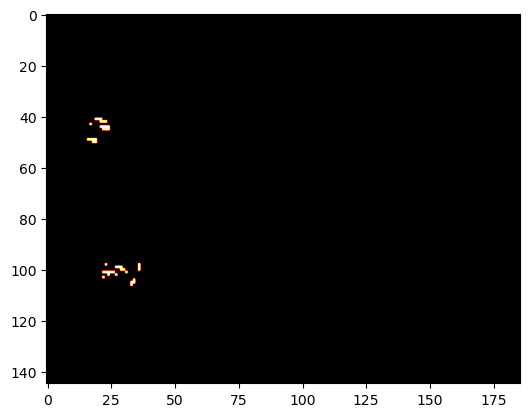

In [29]:
plt.imshow(voxmask_tight[:,:,60], cmap='afmhot')

In [13]:
import pickle
with open(f'/home/rfpred/data/custom_files/subj01/hrf_dict.pkl', 'rb') as file:
    hrf_dict = pickle.load(file)


print_dict_structure(hrf_dict)
# print_large(hrf_dict['subj01']['V1_mask']['voxel1']['hrf_betas'].shape)

subj01
    V1_mask
        voxel1
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel2
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel3
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel4
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel5
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel6
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel7
            xyz
            hrf_betas
            hrf_betas_z
            hrf_rsquared
            hrf_rsquared_z
        voxel8
            xyz
            hrf_betas
            hrf_betas_z
 

In [10]:
full_rms_reg = regression_dict('subj01', 'rms_z', prf_selection_mask, hrf_dict, rms_subj01, n_imgs = 'all')

# ('subj01', feat_type = 'rms_z', voxels = prf_sezection_mask, hrfs = betas_ses1, feat_vals = rms_subj01, n_imgs = 750)

Rewrite so that it extracts the values for every moment in time. These should be added to the dict as a separate beta column, which has as much elements as there are images presented, so 30.000/ subj. Similar structure as the reg_dict, but cannot combine as that one eventually relies on this one. 

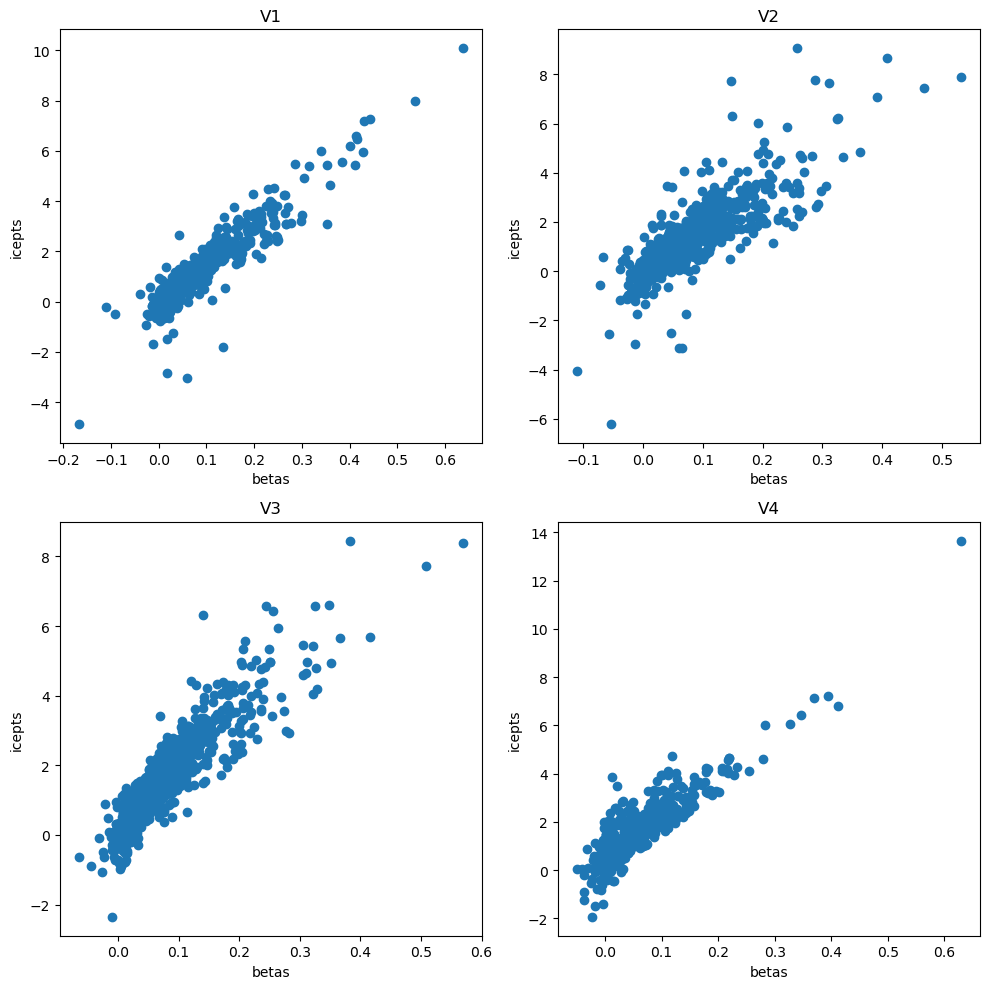

In [128]:
reg_dict = full_rms_reg[0]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']

for i, roi in enumerate(rois):
    betas = [reg_dict[roi][vox]['beta'] for vox in reg_dict[roi]]
    icepts = [reg_dict[roi][vox]['icept'] for vox in reg_dict[roi]]
    
    row = i // 2
    col = i % 2
    
    axs[row, col].scatter(betas, icepts)
    axs[row, col].set_xlabel('betas')
    axs[row, col].set_ylabel('icepts')
    axs[row, col].set_title(roi[:2])
    
plt.tight_layout()
plt.show()


/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])
/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])
/tmp/ipykernel_22721/4263051743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is 

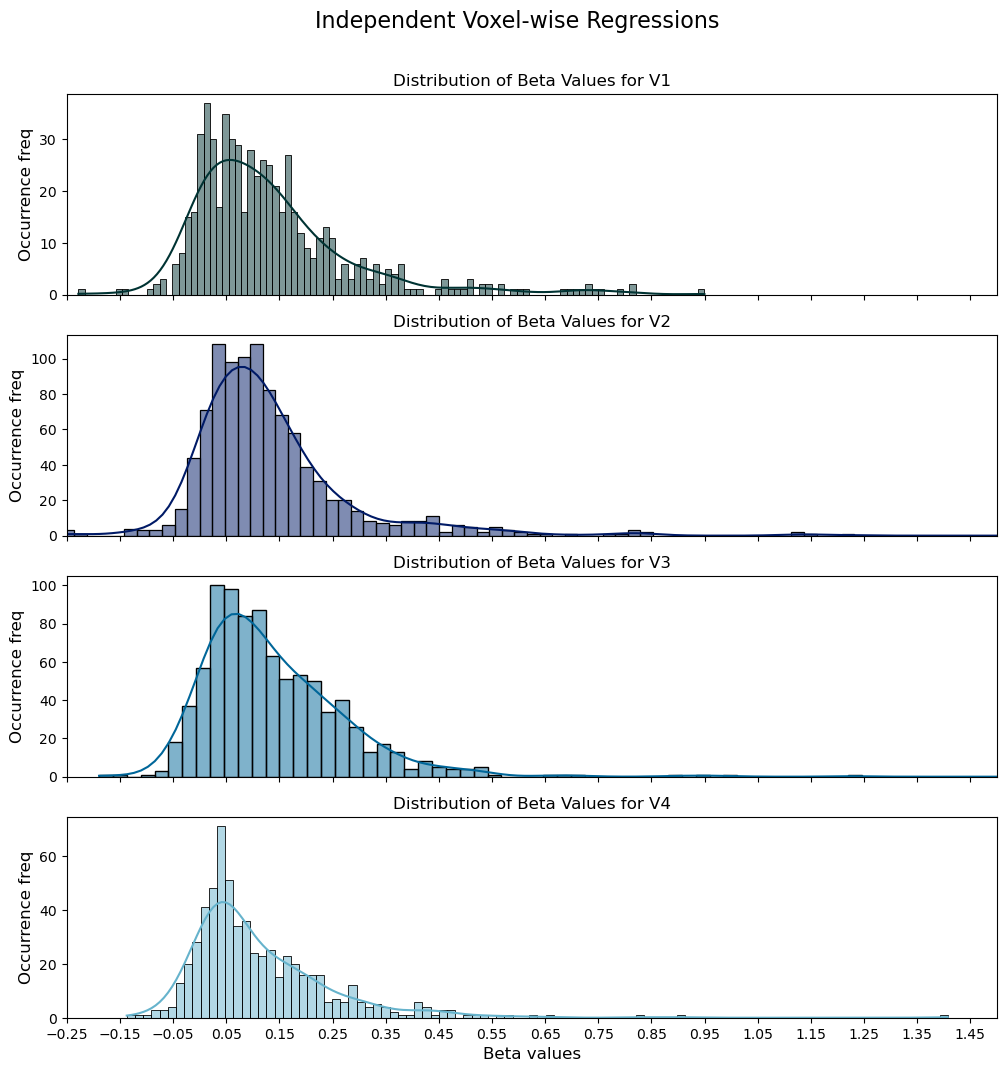

In [481]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_roi_heatmap(reg_dict, roi, ax, color):
    voxels = reg_dict[roi]
    
    # Create a DataFrame where each row corresponds to a voxel
    df = pd.DataFrame(columns=['Voxel', 'Beta', 'Intercept'])
    for voxel_name, voxel_data in voxels.items():
        intercept = voxel_data['icept'].item() if isinstance(voxel_data['icept'], np.ndarray) else voxel_data['icept']
        beta = voxel_data['beta'].item() if isinstance(voxel_data['beta'], np.ndarray) else voxel_data['beta']
        df = pd.concat([df, pd.DataFrame({'Voxel': [voxel_name], 'Beta': [beta], 'Intercept': [intercept]})])  
    
    # Create a histogram to count the frequency of beta values
    sns.histplot(df['Beta'], bins=100, kde=True, color=color, ax=ax)
    ax.set_title(f'Distribution of Beta Values for {roi[:2]}')
    ax.set_xlabel('Beta values', fontsize=12, weight = 'normal')
    ax.set_ylabel('Occurrence freq', weight = 'normal', fontsize=12)
    ax.set_xlim(-0.25, 1.5)  # Set the same x range for all subplots
    ax.set_xticks(np.arange(-0.25, 1.5, 0.1))  # Set the ticks to be more frequent

# Create a single figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# 'ocean' colormap
colors = sns.color_palette("ocean", n_colors=4)

# Call the function for each ROI with the corresponding subplot and color
rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']  # replace with your actual ROIs
for roi, ax, color in zip(rois, axs, colors):
    plot_roi_heatmap(reg_dict, roi, ax, color)

# Add a global title to the figure
fig.suptitle('Independent Voxel-wise Regressions', fontsize=16, y=.95)

plt.show()  # Show the overall figure


In [219]:
# import seaborn as sns
# def plot_roi_beta_distribution(reg_dict):
#     fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
#     colors = sns.color_palette('ocean', n_colors=len(reg_dict))

#     max_y = 0  # Initialize maximum y limit

#     for i, (roi, voxels) in enumerate(reg_dict.items()):
#         beta_values = np.concatenate([voxel_data['beta'] for voxel_data in voxels.values()])
#         sns.histplot(beta_values, kde=True, ax=axes[i], color=colors[i], label=f'{roi} ROI')

#         axes[i].set_title(f'Distribution of Beta Values for {roi[:2]}')
#         axes[i].set_ylabel('Occurrence freq', weight = 'normal', fontsize = 12)
#         axes[i].set_xlim(-1, 2)  # Set the same x range for all subplots
#         axes[i].set_xticks(np.arange(-1, 15, .5))  # Set the ticks to be more frequent
#         axes[i].set_xlabel('Beta values', weight = 'normal', fontsize = 12)

#         # Update maximum y limit
#         max_y = max(max_y, axes[i].get_ylim()[1])

#     # Set the same y range for all subplots
#     for ax in axes:
#         ax.set_ylim(0, max_y)
#         # ax.label_outer()  # Only show x-axis label and ticks on the outermost subplots

#     # axes[-1].set_xlabel('Beta values', weight = 'normal', fontsize = 12)
#     fig.suptitle('Multivariate regression approach (Subject 1, all images, HRF beta)', fontsize=16, y=1)

#     plt.tight_layout()
#     plt.show()

In [111]:
def regression_dict_multivariate(subject, feat_type, voxels, hrfs, feat_vals, n_imgs='all', z_score = 'n'):
    reg_dict = {}
    
    # Set the amount of images to regress over in case all images are available.
    if n_imgs == 'all':
        n_imgs = len(feat_vals)
    
    X = np.array(feat_vals[feat_type][:n_imgs]).reshape(n_imgs, 1)  # Set the input matrix for the regression analysis
    
    # This function will run the multiple regression analysis for each voxel, roi, image, for a subject.
    rois = list(voxels[subject].keys())

    for roi in rois:
        reg_dict[roi] = {}
        voxel_mask = voxels[subject][roi]  # These are the boolean mask for the specific subject, roi
        n_voxels = np.sum(voxel_mask).astype('int')  # This is the number of voxels in this roi
        vox_indices = np.column_stack(np.where(voxel_mask == 1))  # Get voxel indices for the current ROI
        
        # Extract y_matrix for all voxels within the ROI
        
        y_matrix = np.array([hrfs[subject][roi][f'voxel{voxel + 1}']['hrf_betas'] for voxel, xyz in enumerate(vox_indices)]).T #/ 300


        # Perform multivariate regression
        beta_values, intercept_values, rsquared_values = multivariate_regression(X, y_matrix)

        for voxel, vox_idx in enumerate(vox_indices):
            reg_dict[roi][f'vox{voxel}'] = {
                'xyz': list(vox_idx),
                'beta': beta_values[:, voxel],
                'R2': rsquared_values[voxel],
                'icept': intercept_values[voxel]
            }
            
    if z_score == 'y':
        y_matrix = get_zscore(y_matrix, print_ars = 'n')

    return reg_dict, X, y_matrix

def plot_roi_beta_distribution(reg_dict, z_score = None, icept_correct = None, feat_type = ''):
    
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    colors = sns.color_palette('ocean', n_colors=len(reg_dict))
    num_bins = 30  # Specify the number of bins
    icept_values = []
    for i, (roi, voxels) in enumerate(reg_dict.items()):
        beta_values = np.concatenate([voxel_data['beta'] for voxel_data in voxels.values()])
        plot_vals = beta_values
        icept_values = np.concatenate([np.array([voxel_data['icept']]) for voxel_data in voxels.values()])        

        if icept_correct == 'y':
            plot_vals = beta_values / get_zscore(icept_values, print_ars = 'n')

        sns.histplot(plot_vals, kde=True, ax=axes[i], color=colors[i], label=f'{roi} ROI', bins=num_bins)  # Specify the bins

        axes[i].set_title(f'Distribution of Beta Values for {roi[:2]}\n'
                        f'n_voxels={len(voxels)}')
        axes[i].set_ylabel('Occurrence freq', weight = 'normal', fontsize = 12)
        axes[i].set_xlim(-1, 2)  # Set the same x range for all subplots

        axes[i].set_xticks(np.arange(-1, 15, .5))  # Set the ticks to be more frequent

    axes[-1].set_xlabel('Beta values', weight = 'normal', fontsize = 12)
    fig.suptitle(f'Multivariate regression approach (Subject 1, all images, HRF beta) {feat_type}', fontsize=16, y=1)

    plt.tight_layout()
    plt.show()

#### Vogel uit of het goed gaat met de n_voxels, er lijkt iets raars aan de hand te zijn, met name als het gaat om het restrictie argument in de hrf functie.

### Regression on voxels with pRF location in the center of the visual field

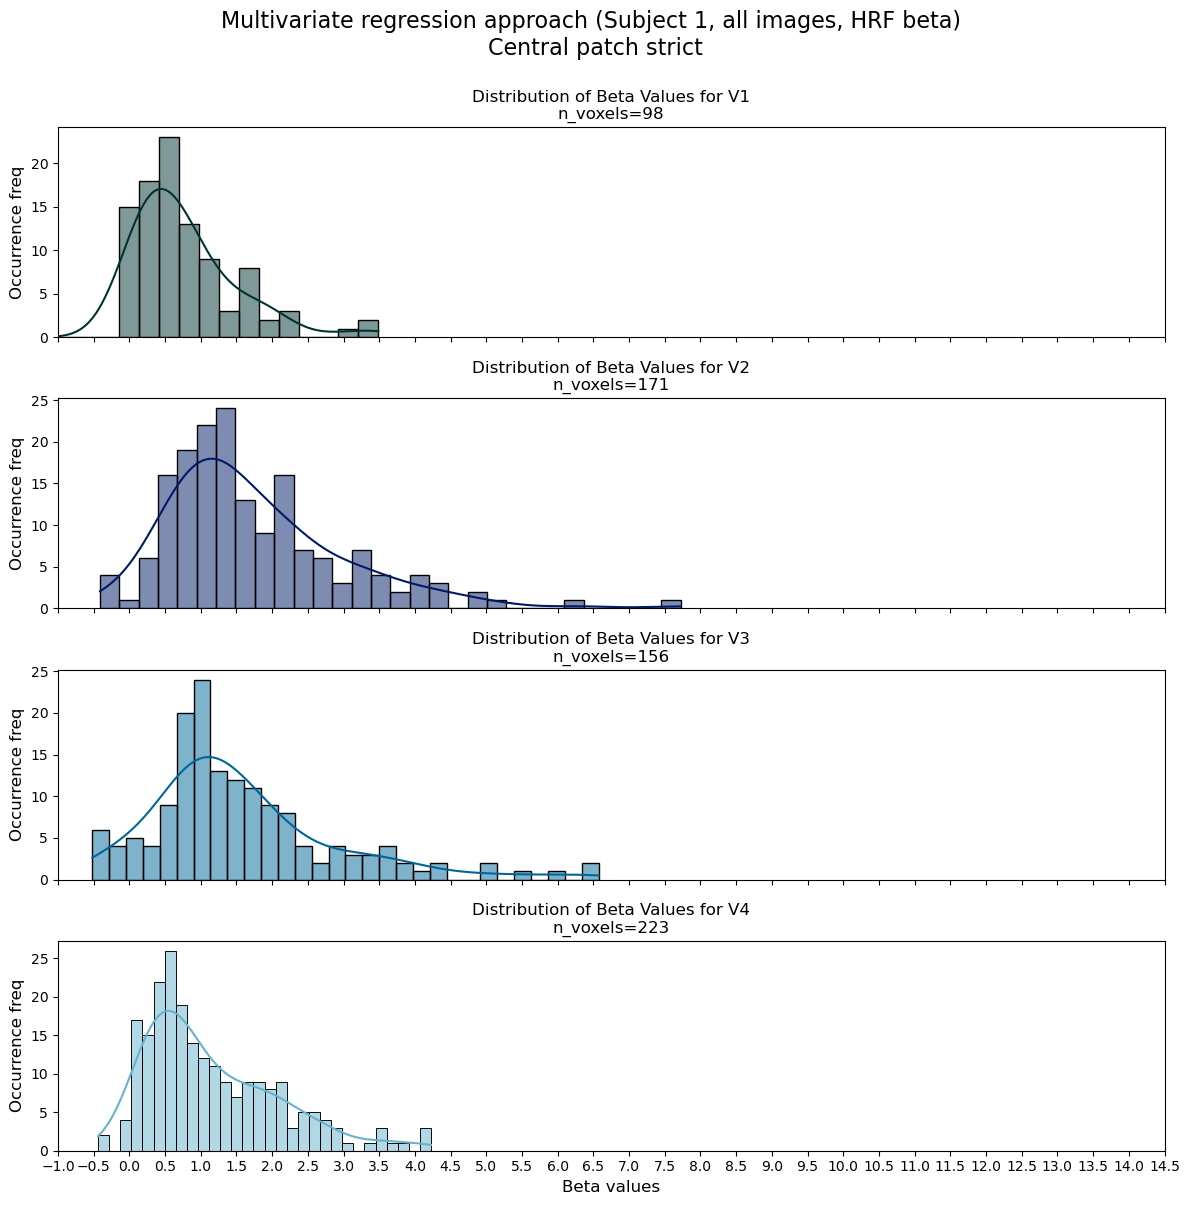

In [114]:
# restricted prfs from .2 to 1 prf_size. All images
# hrf_dict_tight, voxmask_tight
# rois_to_plot = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', 
                                                                                            voxmask_tight, hrf_dict_tight, 
                                                                                            rms_subj01, n_imgs=30000, z_score = 'y')
plot_roi_beta_distribution(reg_dict_multivariate, z_score = 'n', icept_correct = 'n', feat_type = '\nCentral patch strict')

### Loose central prfs regression

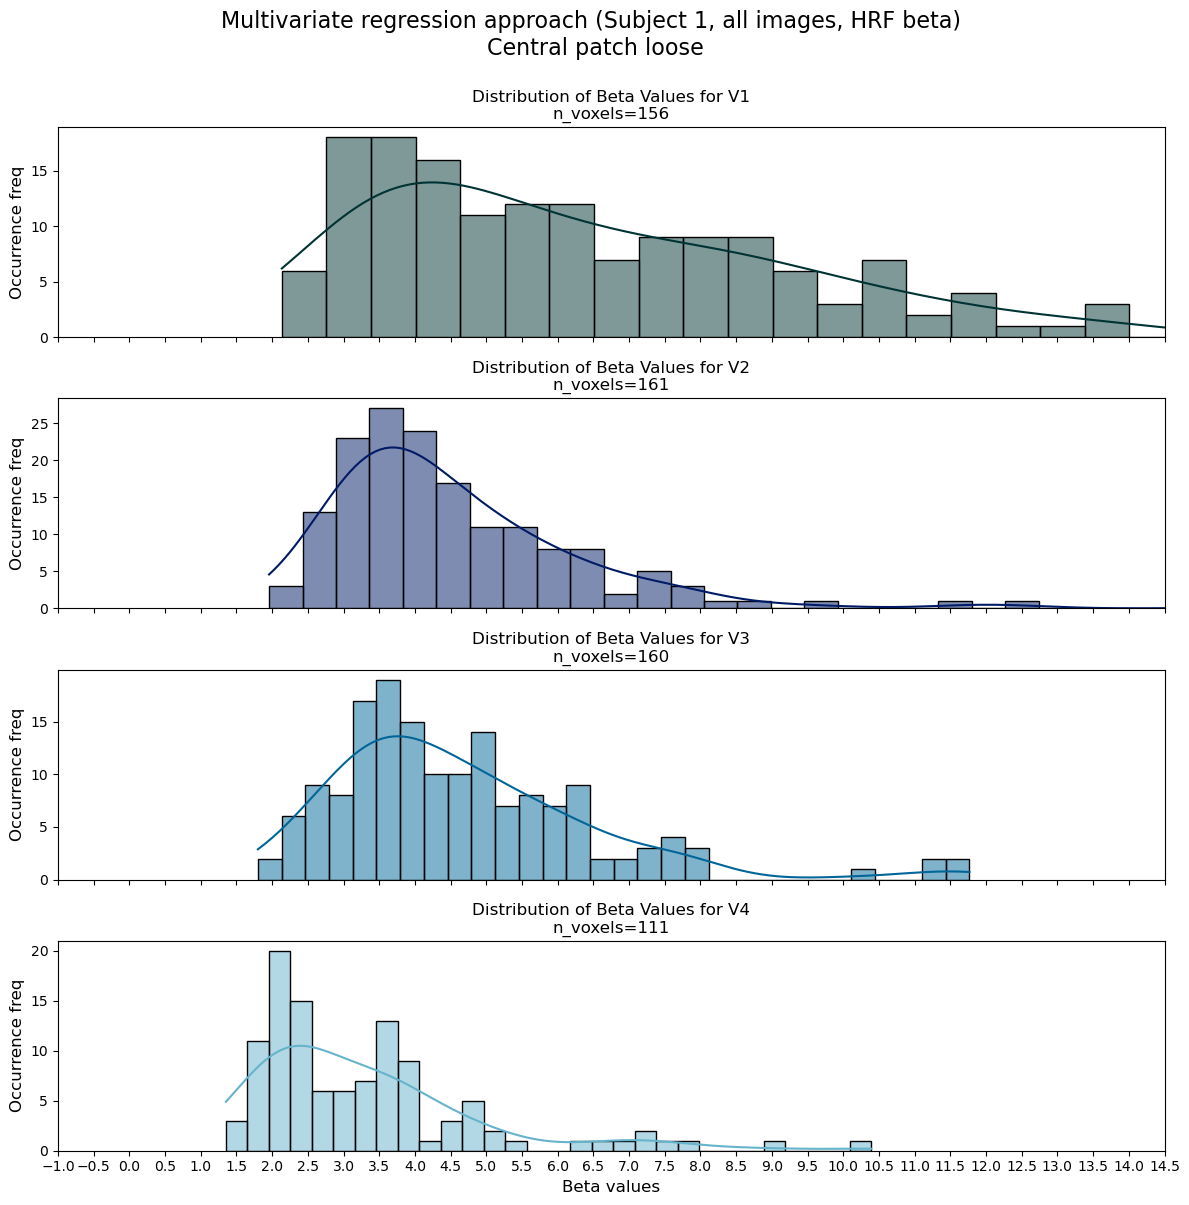

In [118]:
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', 
                                                                                            voxmask_tight_central_loose, hrf_dict_central_loose, 
                                                                                            rms_subj01, n_imgs=30000, z_score = 'y')
plot_roi_beta_distribution(reg_dict_multivariate, z_score = 'n', icept_correct = 'n', feat_type = '\nCentral patch loose')

### Regression on voxels with pRF location in periphery of the visual field

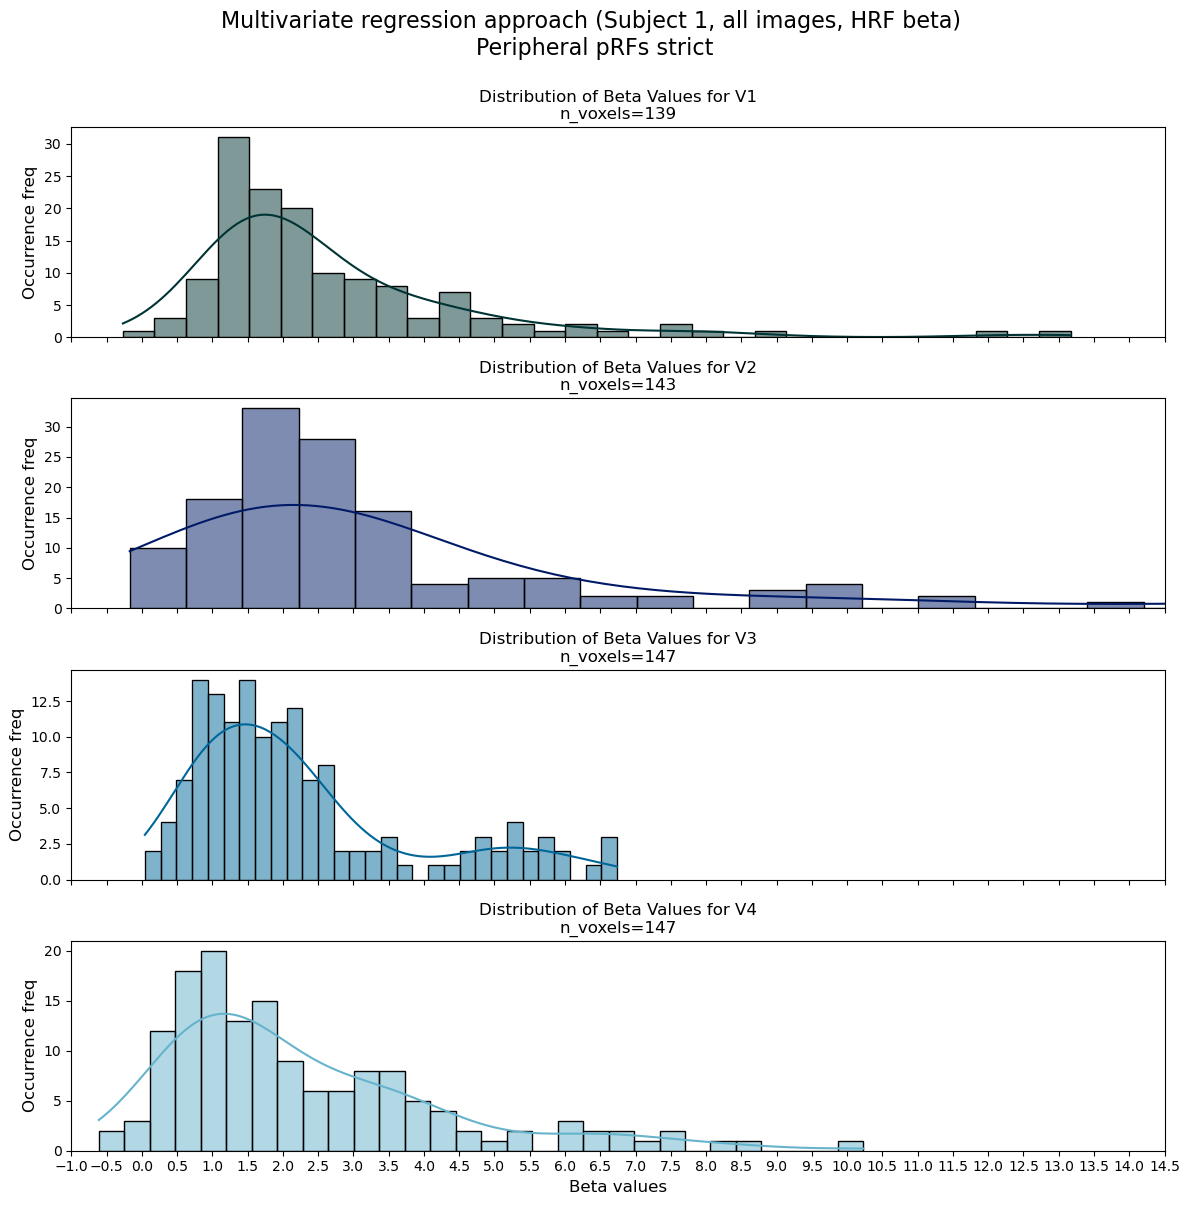

In [110]:
# hrf_dict_peri, voxmask_tight_peri 


reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', 
                                                                                            voxmask_tight_peri, hrf_dict_peri, 
                                                                                            rms_subj01, n_imgs=30000, z_score = 'y')
plot_roi_beta_distribution(reg_dict_multivariate, z_score = 'n', icept_correct = 'n', feat_type = '\nPeripheral pRFs strict')

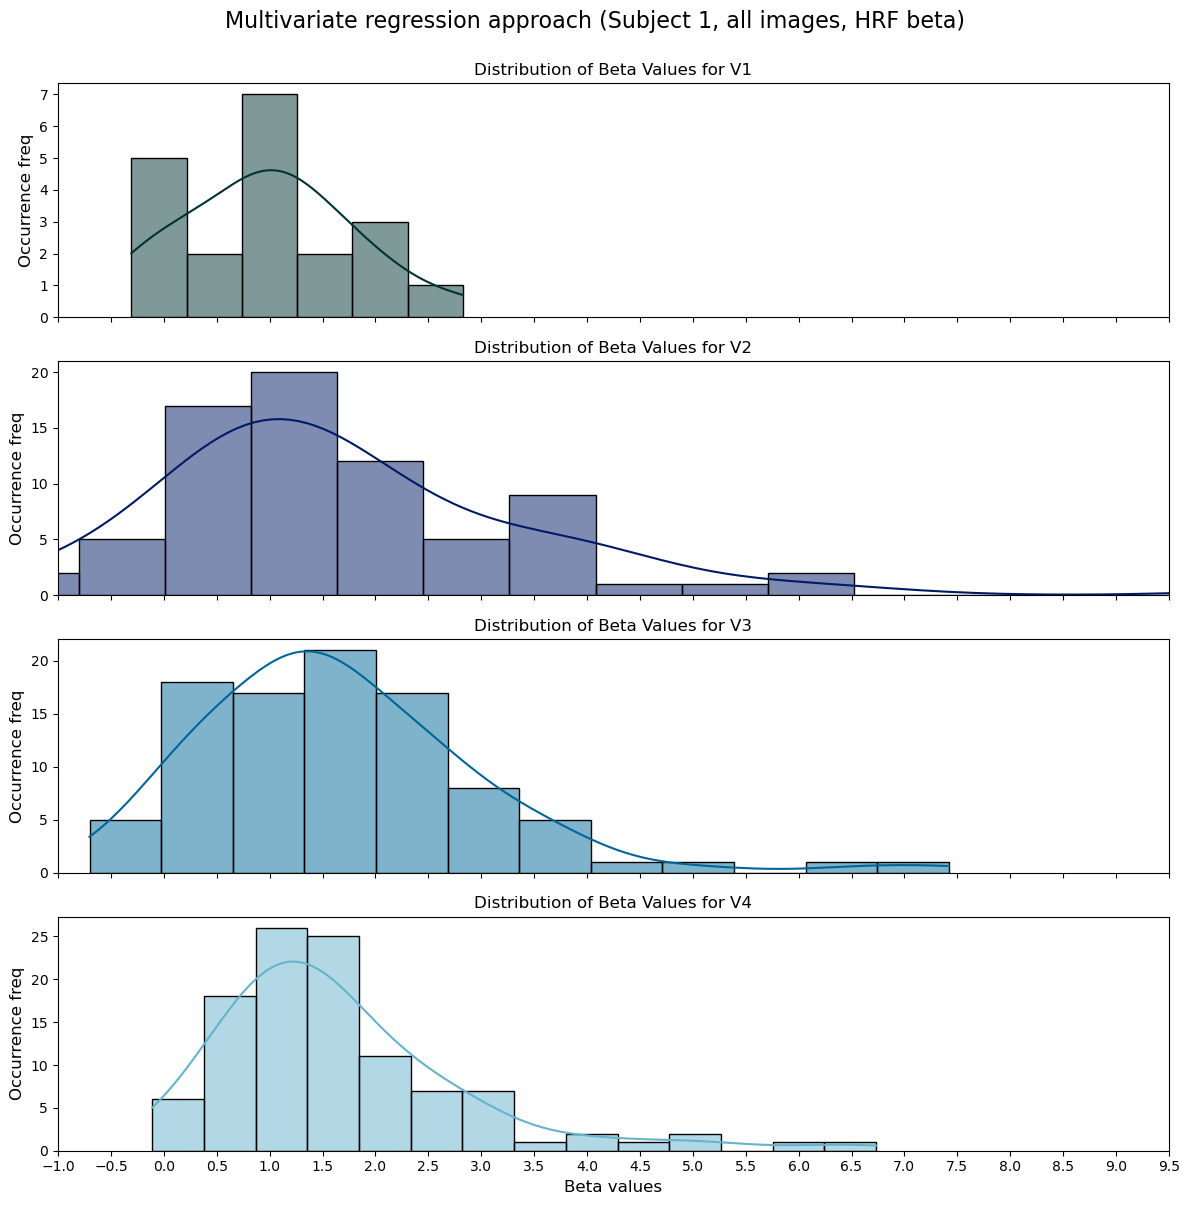

In [22]:
# new_hrf_dict_central

rois_to_plot = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', new_central_mask, new_hrf_dict_central, rms_subj01, n_imgs=6000)
plot_roi_beta_distribution(reg_dict_multivariate)

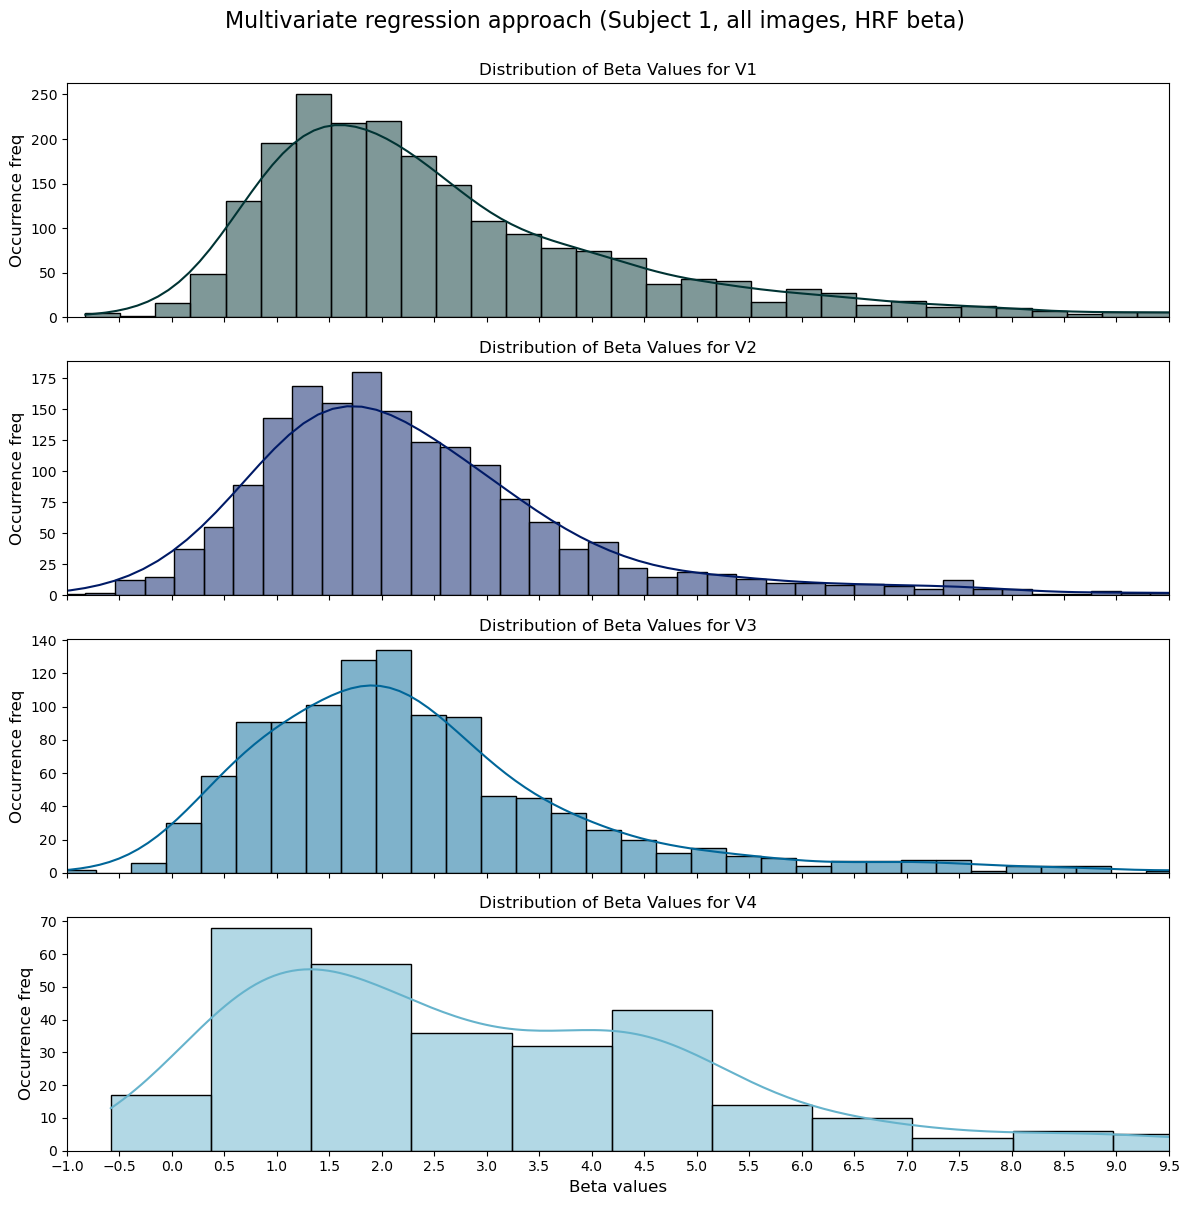

In [22]:


# # Example usage
rois_to_plot = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', prf_mask_periphery_strict, hrf_dict_periphery, rms_subj01, n_imgs=1500)
plot_roi_beta_distribution(reg_dict_multivariate)

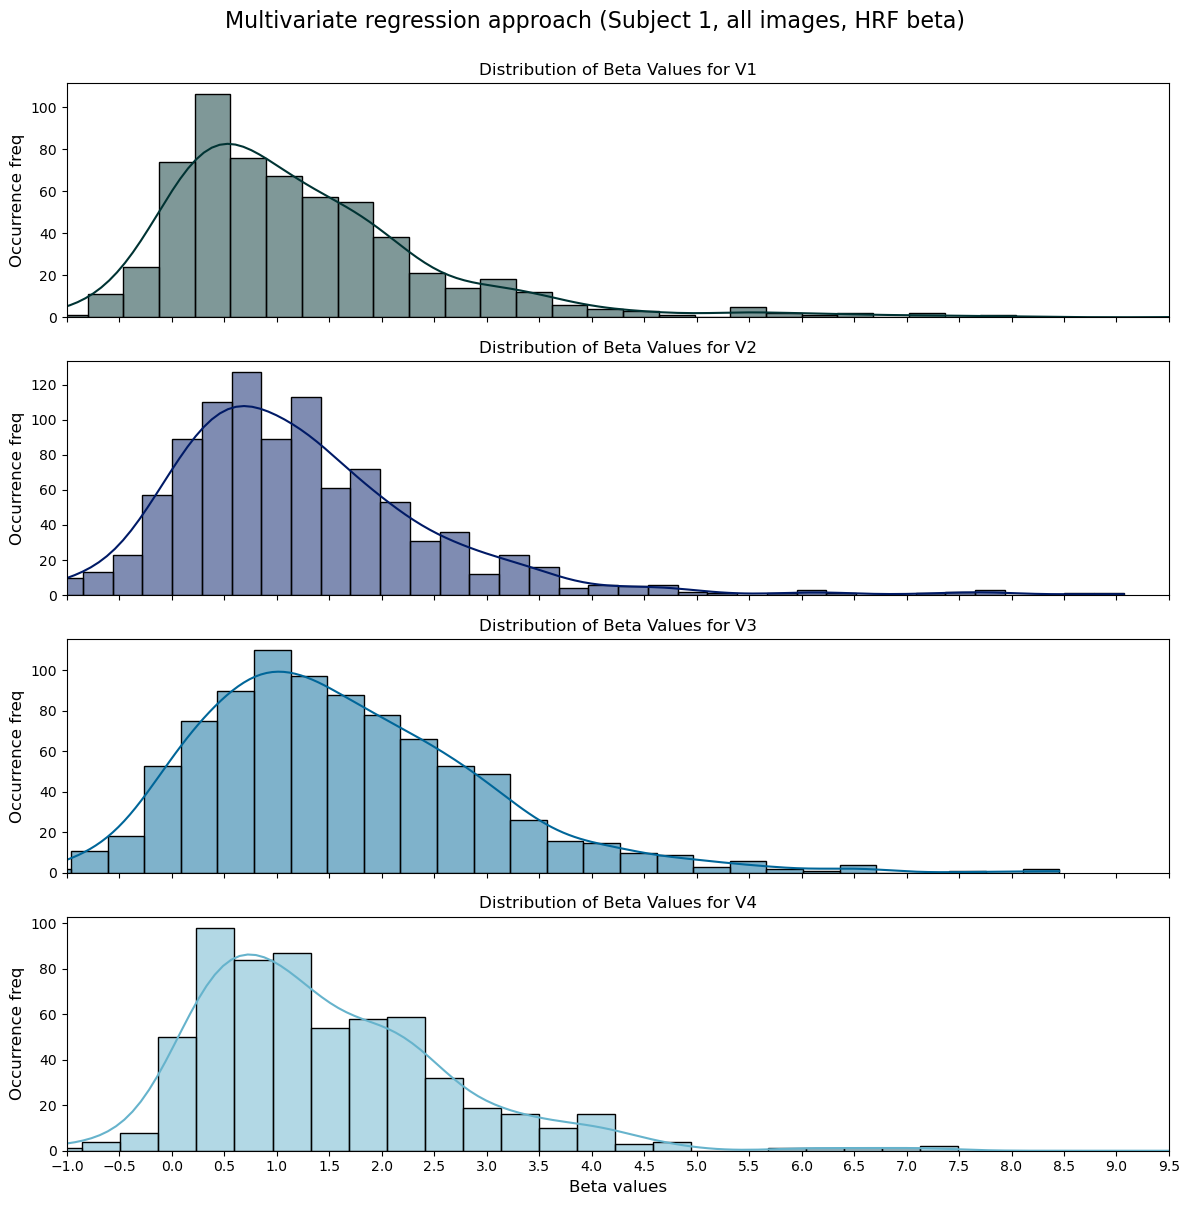

In [38]:
# This is for all of them. Center patch

# # Example usage
rois_to_plot = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']
reg_dict_multivariate, X_multivariate, y_matrix_multivariate = regression_dict_multivariate('subj01', 'rms_z', prf_selection_mask, hrf_dict, rms_subj01, n_imgs=30000)
plot_roi_beta_distribution(reg_dict_multivariate)

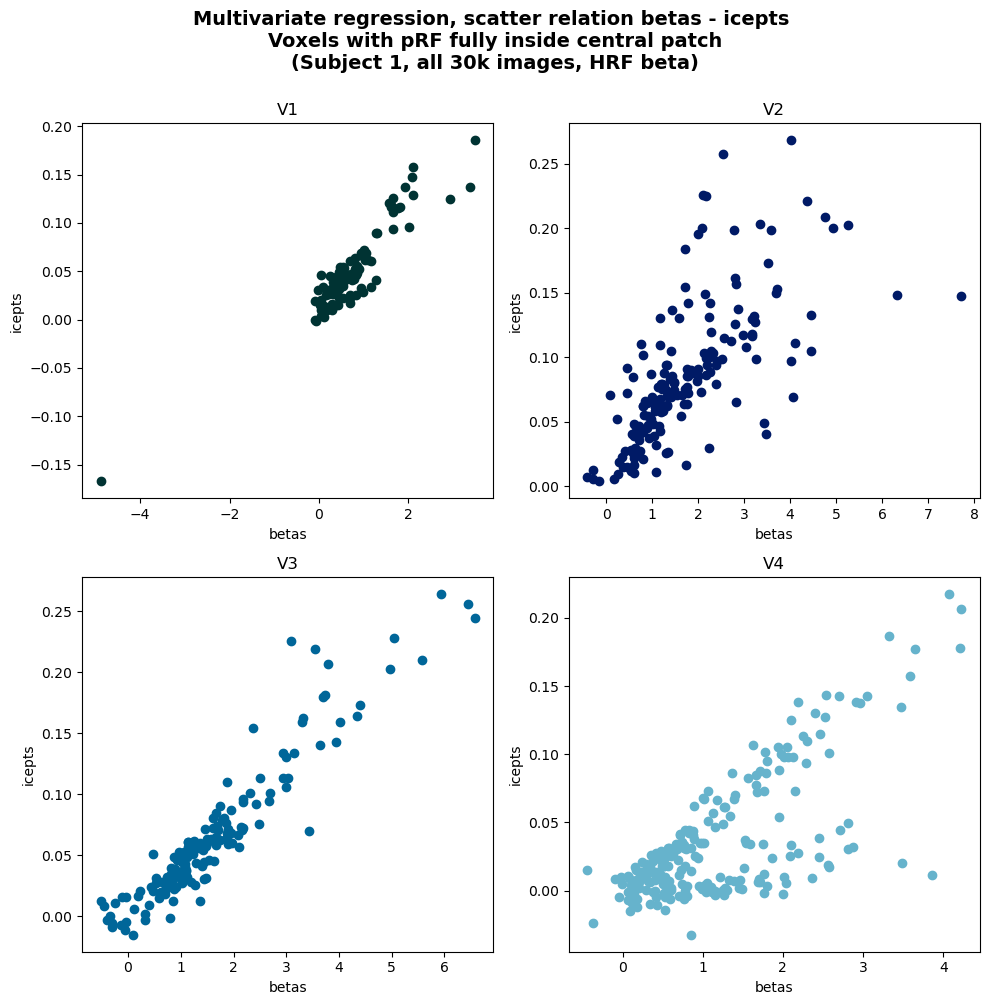

In [117]:
# Define a list of colors
# colors = ['blue', 'orange', 'green', 'red']
colors = sns.color_palette('ocean', n_colors=len(reg_dict_multivariate))

# Plot the relation between beta values and intercepts for each ROI of the multivariate regression.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']

for i, roi in enumerate(rois):
    betas = [reg_dict_multivariate[roi][vox]['beta'] for vox in reg_dict_multivariate[roi]]
    icepts = [reg_dict_multivariate[roi][vox]['icept'] for vox in reg_dict_multivariate[roi]]
    
    row = i // 2
    col = i % 2
    
    axs[row, col].scatter(betas, icepts, color=colors[i])  # Use the color
    axs[row, col].set_xlabel('betas')
    axs[row, col].set_ylabel('icepts')
    axs[row, col].set_title(roi[:2])
fig.suptitle('Multivariate regression, scatter relation betas - icepts \nVoxels with pRF fully inside central patch\n(Subject 1, all 30k images, HRF beta)', fontsize=14, y=1, weight = 'bold')

plt.tight_layout()
plt.show()

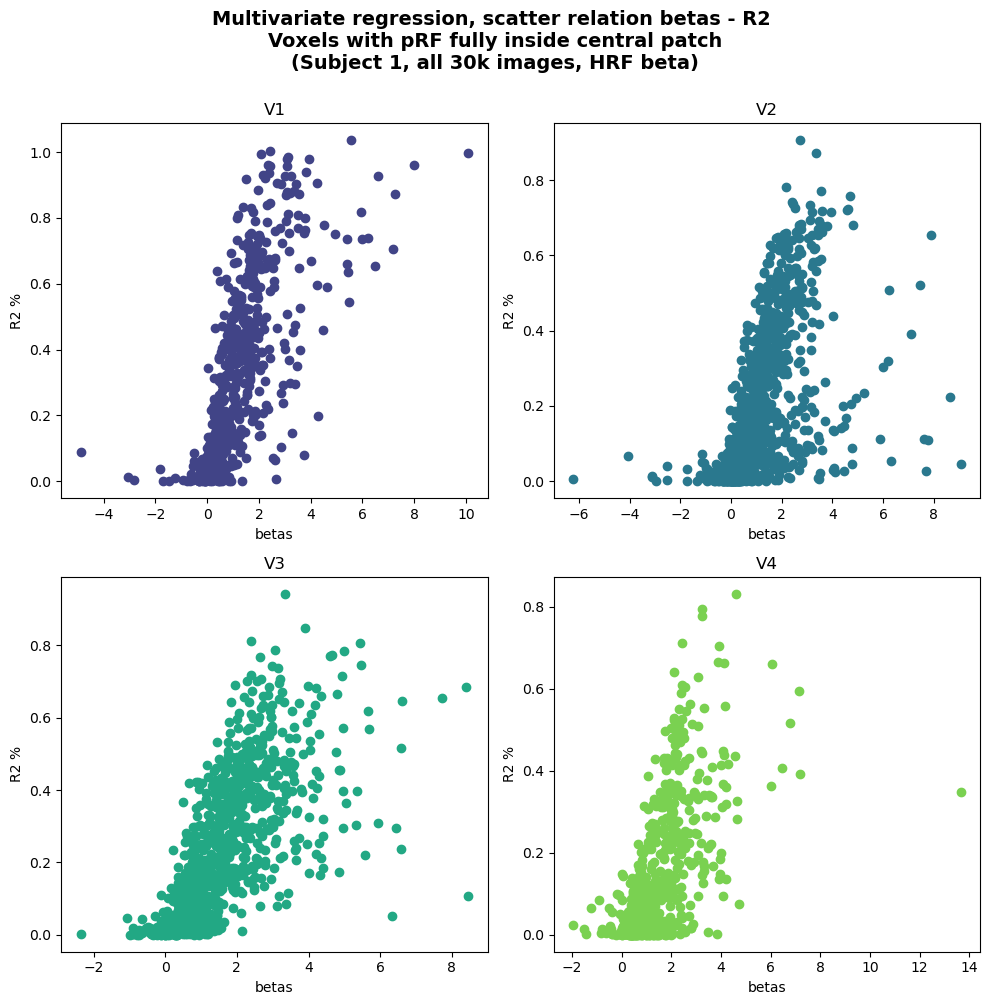

In [36]:
# Define a list of colors
# colors = ['blue', 'orange', 'green', 'red']
colors = sns.color_palette('viridis', n_colors=len(reg_dict_multivariate))

# Plot the relation between beta values and intercepts for each ROI of the multivariate regression.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rois = ['V1_mask', 'V2_mask', 'V3_mask', 'V4_mask']

for i, roi in enumerate(rois):
    betas = [reg_dict_multivariate[roi][vox]['beta'] for vox in reg_dict_multivariate[roi]]
    # icepts = [reg_dict_multivariate[roi][vox]['icept'] for vox in reg_dict_multivariate[roi]]
    rsquared = [reg_dict_multivariate[roi][vox]['R2']*100 for vox in reg_dict_multivariate[roi]]
    
    row = i // 2
    col = i % 2
    
    axs[row, col].scatter(betas, rsquared, color=colors[i])  # Use the color
    axs[row, col].set_xlabel('betas')
    axs[row, col].set_ylabel('R2 %')
    axs[row, col].set_title(roi[:2])
fig.suptitle('Multivariate regression, scatter relation betas - R2 \nVoxels with pRF fully inside central patch\n(Subject 1, all 30k images, HRF beta)', fontsize=14, y=1, weight = 'bold')

plt.tight_layout()
plt.show()

In [37]:
reg_dict_multivariate['V1_mask']['vox0']

{'xyz': [56, 7, 76],
 'beta': array([-0.0277]),
 'R2': 0.0007387931623847876,
 'icept': 0.03032391617098908}

In [181]:
# prf_selection_mask['subj01']['V1_mask']

# np.where(prf_selection_mask['subj01']['V1_mask'] == True)

OUTDATED CODE, NOT NEEDED. RMS_ALL FIXES

In [118]:
testdf = get_contrast_df(100, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center', contrast_type = 'rms_lab')

Processing image number: 0 out of 100
Processing image number: 10 out of 100
Processing image number: 20 out of 100
Processing image number: 30 out of 100
Processing image number: 40 out of 100
Processing image number: 50 out of 100
Processing image number: 60 out of 100
Processing image number: 70 out of 100
Processing image number: 80 out of 100
Processing image number: 90 out of 100


Use these codes to collect the rms values for all the images separately, then later on assign them based on the desing matrices. This saves a lot of time. Check the later code for what is useful and what not. The whole get_contrast_df function should probably be adapted in a way, as it is really not efficient anymore. But it definitely has useful components such as the df creation and uhhhh yeah I guess that's it.

In [9]:
from multiprocessing import Pool

# These two functions are coupled to run the feature computations in parallel.
# This saves a lot of time. Should be combined with the feature_df function to assign
# the values to the corresponding trials.
def rms_single(args, ecc_max = 1, loc = 'center'):
    i, start, n, loc = args
    dim = show_stim(hide = 'y')[0].shape[0]
    radius = ecc_max * (dim / 8.4)

    if loc == 'center':
        x = y = (dim + 1)/2
    elif loc == 'irrelevant_patch':
        x = y = radius + 10
        
    mask_w_in = css_gaussian_cut(dim, x, y, radius)
    rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    ar_in = show_stim(img_no = i, hide = 'y')[0]  
    
    if i % 100 == 0:
        print(f"Processing image number: {i} out of {n + start}")
    return get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n')


def rms_all(start, n, ecc_max = 1, loc = 'center'):
    img_vec = list(range(start, start + n))

    # Create a pool of worker processes
    with Pool() as p:
        rms_vec = p.map(rms_single, [(i, start, n, loc) for i in img_vec])

    rms_dict = pd.DataFrame({
        'rms': rms_vec
    })

    rms_dict = rms_dict.set_index(np.array(img_vec))
    return rms_dict


In [10]:
rms_irrelevant = rms_all(start = 0, n = 1000, loc = 'irrelevant_patch')

Processing image number: 0 out of 1000
Processing image number: 100 out of 1000
Processing image number: 200 out of 1000
Processing image number: 300 out of 1000
Processing image number: 400 out of 1000
Processing image number: 500 out of 1000
Processing image number: 600 out of 1000
Processing image number: 700 out of 1000
Processing image number: 800 out of 1000
Processing image number: 900 out of 1000


In [12]:
rms_test = rms_all(start = 72998, n = 2)
rms_test

rms
72998  28.464819
72999  18.567823

In [10]:
rms_test.to_pickle('rms_lab_df_20-50k.pkl')
# rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

In [13]:


latest_rms = pd.read_pickle('all_rms_lab_df_72k')
all_rms = pd.DataFrame({'rms': np.append(latest_rms['rms'], rms_test['rms'])})

print(all_rms)
all_rms.to_pickle('all_rms_lab_df')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
72995  32.597843
72996  19.921272
72997  54.109564
72998  28.464819
72999  18.567823

[73000 rows x 1 columns]


##### THink about whether I need to reduce them to z-scores. I think I need to do that, but I'm not sure actually. Probably yes, because then we've got a universal standardized measure. I've got a function for it anyway, in the utility.py file.

<Axes: >

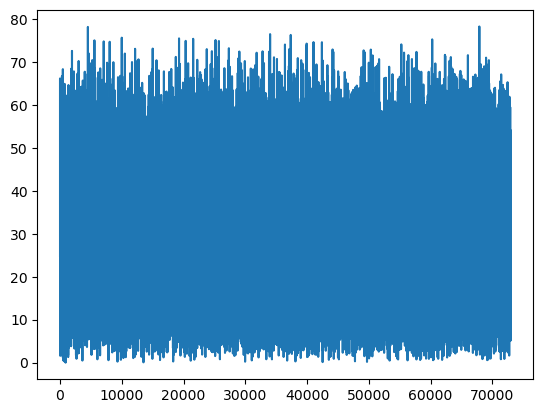

In [15]:
all_rms['rms'].plot()

These RMS values have been collected based on the LAB lightness, or luminance values. This is postulated as being the best representative for human visual perception.

Yes and it is very slow. This took more than an hour, and now I've got a version that does the same in 10 min.

In [5]:
rms_lab_df_10k = get_contrast_df(10000, start_img_no = 0, roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', prf_proc_dict = prf_dict, binary_masks = vismask_dict, rf_type = 'center')
rms_lab_df_10k.to_pickle('rms_lab_df_10k.pkl')

Processing image number: 0 out of 10000
Processing image number: 10 out of 10000
Processing image number: 20 out of 10000
Processing image number: 30 out of 10000
Processing image number: 40 out of 10000
Processing image number: 50 out of 10000
Processing image number: 60 out of 10000
Processing image number: 70 out of 10000
Processing image number: 80 out of 10000
Processing image number: 90 out of 10000
Processing image number: 100 out of 10000
Processing image number: 110 out of 10000
Processing image number: 120 out of 10000
Processing image number: 130 out of 10000
Processing image number: 140 out of 10000
Processing image number: 150 out of 10000
Processing image number: 160 out of 10000
Processing image number: 170 out of 10000
Processing image number: 180 out of 10000
Processing image number: 190 out of 10000
Processing image number: 200 out of 10000
Processing image number: 210 out of 10000
Processing image number: 220 out of 10000
Processing image number: 230 out of 10000
Pro

In [11]:
rms_lab_subj01 = pd.read_pickle('/home/rfpred/rms_lab_df_10k.pkl')
rms_lab_subj01.shape[0]

# Standardize the root mean square values by turning them into z-scores
# rms_lab_z = get_zscore(rms_lab_subj01['rms'], print_ars = 'n')
# rms_lab_subj01['rms'] = rms_lab_z

rms_lab_subj01['image_id'][0]

rms_lab_subj01[000:100]

FileNotFoundError: [Errno 2] No such file or directory: '/home/rfpred/rms_lab_df_10k.pkl'

#### The following 3 code sections involve the old RMS computations

These are wrong, as the values do not correspond with the image_id, but actually only with the first 30.000 images of the 73.000 dataset. not very useful at all.

In [205]:
all_rms = pd.DataFrame({'rms': np.append(rms_lab_subj01['rms'], rms_test['rms'])})

print(all_rms)
# all_rms.to_pickle('all_rms_lab_df_20k')

             rms
0      24.850763
1      66.215949
2      15.592134
3      15.113406
4      32.931833
...          ...
19995  30.471547
19996  43.315133
19997  28.705528
19998  11.648056
19999  24.322731

[20000 rows x 1 columns]


In [131]:
rms_subj01 = pd.read_pickle('/home/rfpred/all_rms_lab_df.pkl')
rms_subj01.shape[0]

73000

In [132]:
# Standardize the root mean square values by turning them into z-scores
rms_z = get_zscore(rms_subj01['rms'], print_ars = 'n')
rms_subj01['rms_z'] = rms_z

In [133]:
rms_subj01


rms     rms_z
0      24.850763 -0.113239
1      66.215949  3.263606
2      15.592134 -0.869067
3      15.113406 -0.908148
4      32.931833  0.546459
...          ...       ...
72995  32.597843  0.519193
72996  19.921272 -0.515658
72997  54.109564  2.275302
72998  28.464819  0.181794
72999  18.567823 -0.626146

[73000 rows x 2 columns]

In [95]:
def get_contrast_df(n_images = None, start_img_no = 0 ,roi = 'V1', subject = 'subj01', ecc_max = 1, ecc_strict = 'y', 
                     prf_proc_dict = None, binary_masks = None, rf_type = 'prf', contrast_type = 'rms_lab'):
    
    designmx = get_imgs_designmx()
    
    if n_images == 'all':
        n_images = len(designmx['subj01'])
    
    indices, rms_list, image_id_list= [], [], []
      
    img_vec = designmx[subject][start_img_no : n_images + start_img_no]  
    
    # for img_no in range(start_img_no, n_images + start_img_no):
    for n_img, img_id in enumerate(img_vec):
        ar_in = show_stim(img_no = img_id, hide = 'y')[0]
        
        if rf_type == 'prf':
            # Acquire mask based on subject, roi, outline. Type is cut_gaussian by default, based on NSD paper
            rf_info = get_mask(dim = 425, subject = subject, binary_masks = binary_masks, 
                                            prf_proc_dict = prf_proc_dict, type='cut_gaussian', roi=roi,
                                            plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 4.2, 
                                            ecc_max = ecc_max, ecc_strict = ecc_strict)
            
            # Get the location and radius of the patch
            x, y = rf_info['x'].astype('int'), rf_info['y'].astype('int')
            radius = rf_info['pix_radius'].astype('int')
            mask_w_in = rf_info['mask']
            
            # Create boolean mask of exact same size as weighted pRF patch
            rf_mask_in = make_circle_mask(425, x, y, radius, fill = 'y', margin_width = 0)
            
        elif rf_type == 'center':
            dim = ar_in.shape[0]
            x = y = (dim + 1)/2
            radius = ecc_max * (dim / 8.4)
            mask_w_in = css_gaussian_cut(dim, x, y, radius)
            rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
            
        # Get root mean square contrast of image and add to list
        indices.append(n_img)
        
        if contrast_type == 'rms_lab':
            rms_list.append(get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
        elif contrast_type == 'rms':
            rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n'))
            
        # rms_list.append(get_rms_contrast(ar_in, mask_w_in, rf_mask_in, normalise = True))
        image_id_list.append(designmx[subject][n_img])
        # roi_list.append(roi)
        # subject_list.append(subject)
        if n_img % 10 == 0:
            print(f"Processing image number: {n_img} out of {n_images + start_img_no}")

    contrast_df = pd.DataFrame({
        'rms': rms_list,
        'image_id': image_id_list
        # 'roi': roi_list,
        # 'subject': subject_list
    })
    
    # Remove this roi thing, or well, only when rf_type = 'center'
    # contrast_df.insert(2, 'roi', [roi] * contrast_df.shape[0])
    contrast_df.insert(2, 'subject', [subject] * contrast_df.shape[0])
    contrast_df.insert(3, 'central_radius', [ecc_max] * contrast_df.shape[0])
    
    contrast_df = contrast_df.set_index(np.array(indices))
    
    return contrast_df

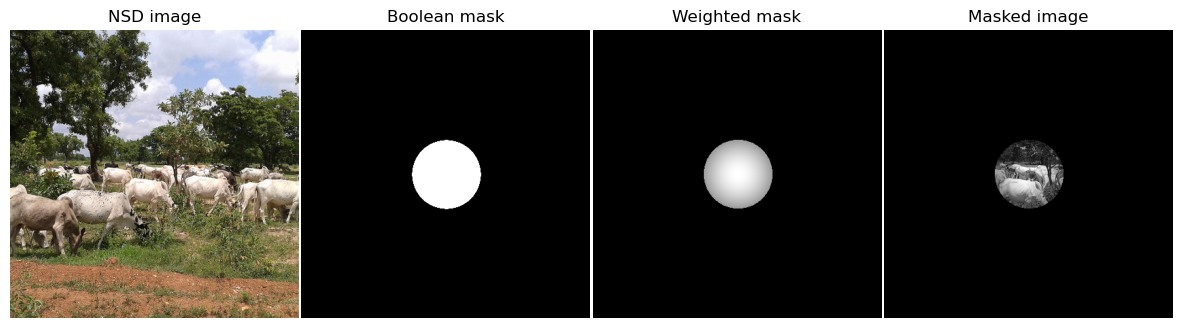

In [19]:
# Choose image from the natural scenes dataset
img_no = 46002 #29

img = show_stim(img_no = img_no, hide = 'y')[0]

# Create the mask and acquire relevant parameters.
info = get_mask(dim = 425, subject = 'subj01', binary_masks = vismask_dict, 
                                        prf_proc_dict = prf_dict, type='outline', roi='V2',
                                        plot = 'n', excl_reason = 'n', sigma_min=0, sigma_max = 1.2, 
                                        ecc_max = 1, fill_outline = 'y', grid = 'y')

weighted_mask = css_gaussian_cut(425, 213, 213, (425/8.4))

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.01)

# Plot the first image in the first subplot
axs[0].imshow(img)
axs[0].set_title('NSD image')
axs[0].axis('off') 
# Plot the second image in the second subplot
axs[2].imshow(weighted_mask, cmap = 'gist_gray')
axs[2].set_title('Weighted mask')
axs[2].axis('off') 
axs[1].imshow(info['mask'], cmap = 'gist_gray')
axs[1].set_title('Boolean mask')
axs[1].axis('off') 

# Plot the weighted masked image in the fourth subplot
weighted_masked_image = np.multiply(np.mean(img, axis = -1), weighted_mask)
axs[3].imshow(weighted_masked_image, cmap = 'gist_gray')
axs[3].set_title('Masked image')
axs[3].axis('off') 
plt.show()


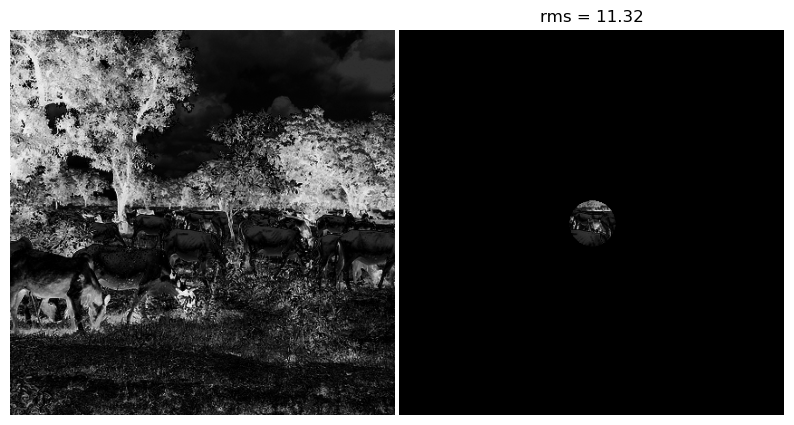

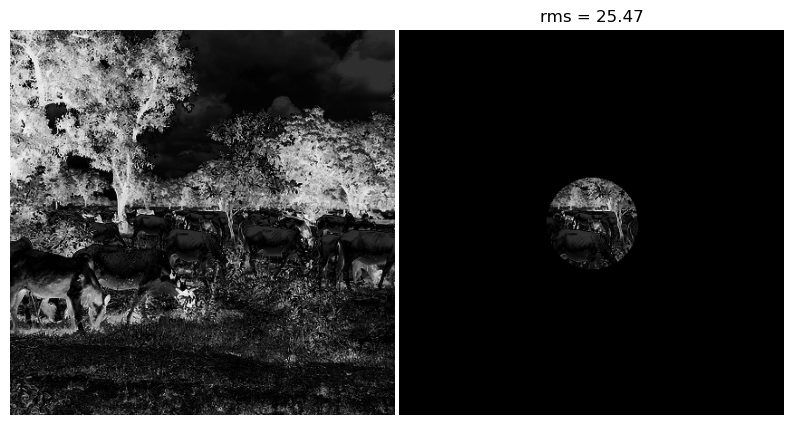

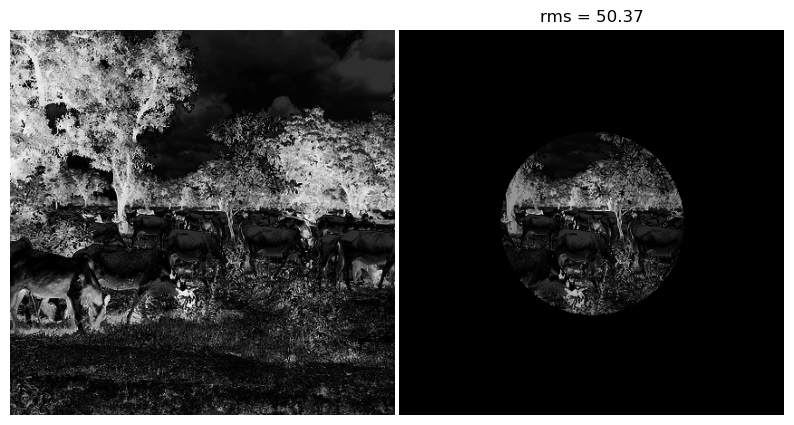

In [20]:
# This is when using the L parameter of the LAB colour space, which is the luminance channel. Best to use.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast_lab(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')

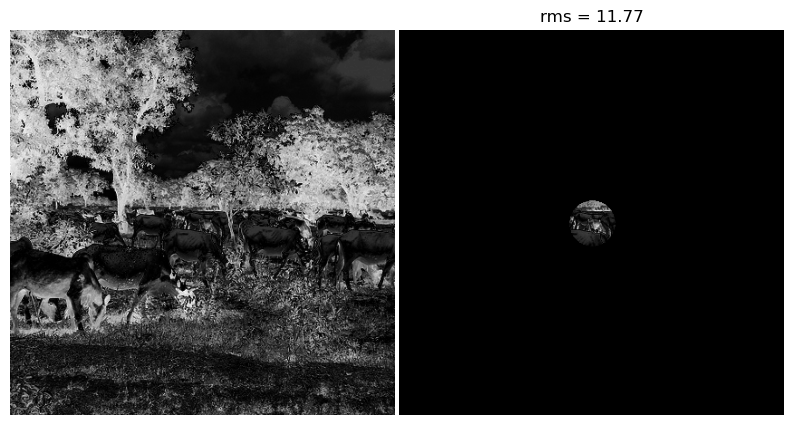

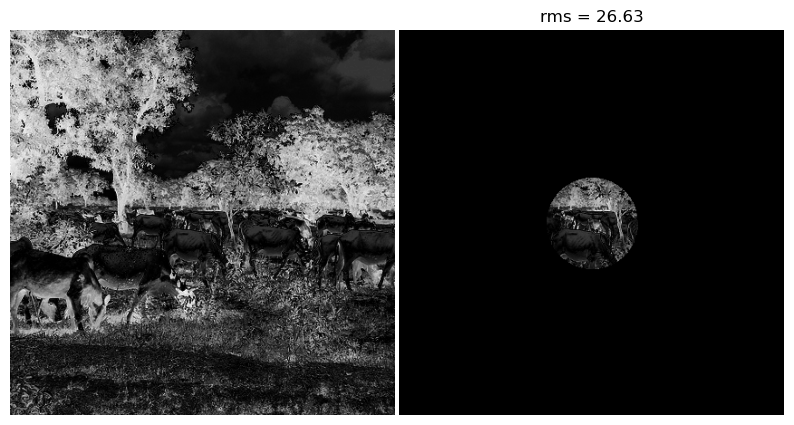

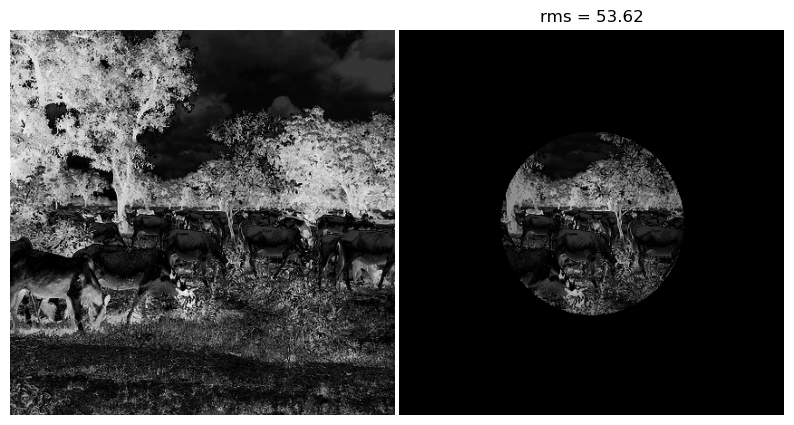

In [21]:
# This is the original RMS function, which does not use the lightness parameter. The differences are minute.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.

tiny = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/16.8)), info['mask'], normalise = True, plot = 'y')

small = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/8.4)), info['mask'], normalise = True, plot = 'y')

big = get_rms_contrast(img, css_gaussian_cut(425, 213, 213, (425/4.2)), info['mask'], normalise = True, plot = 'y')